In [3]:
import os
import numpy as np

from bayes_opt import BayesianOptimization
from bayes_opt.event import Events
from bayes_opt.logger import JSONLogger
from bayes_opt.util import load_logs
from bayes_opt import UtilityFunction

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline


# Specify config file for bayesian optimization
CONFIG_FILE = "first_optimization.yaml"
# If you want to load logs from previous optimization, set this to True
OLD_LOGS = False

# Specify utility function
utility = UtilityFunction(kind="ucb", kappa=10.576, xi=0.0)

# specify black box function
def target(x):
    return np.exp(-(x-2)**2) + np.exp(-(x-6)**2/10) + 1/(x**2 + 1) + (x**2)/100
black_box_func = target

# specify bounds
pbounds = {
    "x": (-10, 10),
    #"y": (-10, 10)
}
# ---------------------------------------------


optimizer = BayesianOptimization(
    f=black_box_func,
    pbounds=pbounds,
    verbose=2,
    bounds_transformer=None,
    allow_duplicate_points=True,
    random_state=1,
)

config_name = CONFIG_FILE.rsplit(".")[0]
# Logging will be done in the logs folder under config_file name in json format
logger = JSONLogger(path=f"./logs/{config_name}.json")

if OLD_LOGS and os.path.exists(f"./logs/{config_name}.json"):
    # Load logs from previous optimization
    load_logs(optimizer, logs=[f"./logs/{config_name}.json"])

optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

In [4]:
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((x.min(), x.max()))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((x.min(), x.max()))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

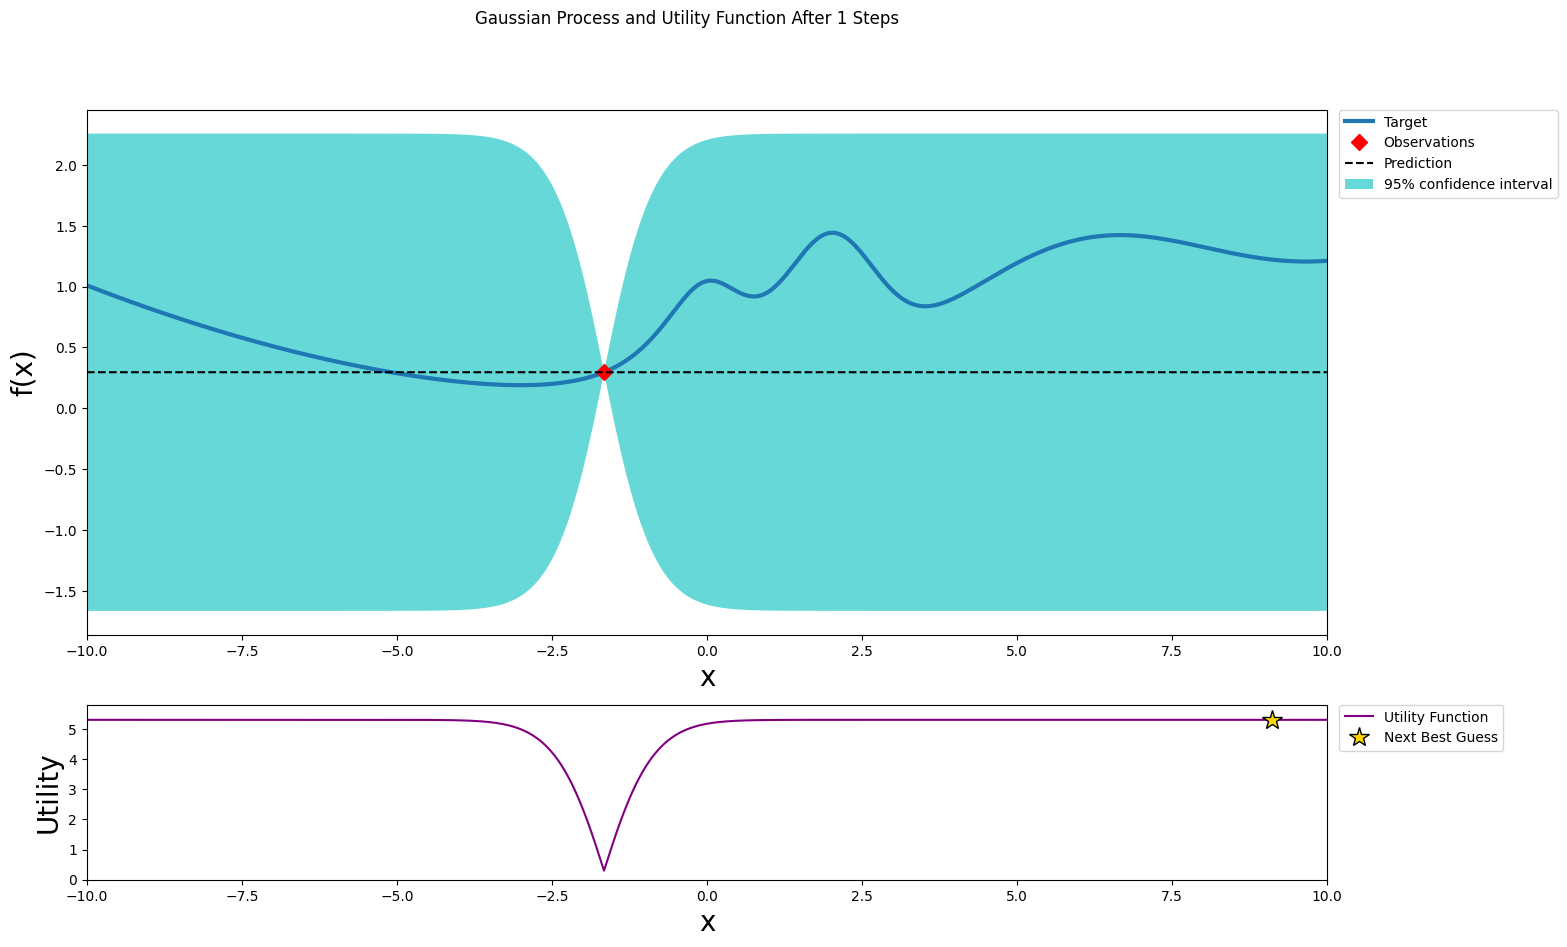

In [5]:
x = np.linspace(-10, 10, 10000).reshape(-1, 1)
y = target(x)

# example of simple optimization
optimizer.maximize(
    init_points=1,
    n_iter=0,
    acquisition_function=utility
)
plot_gp(optimizer, x, y)

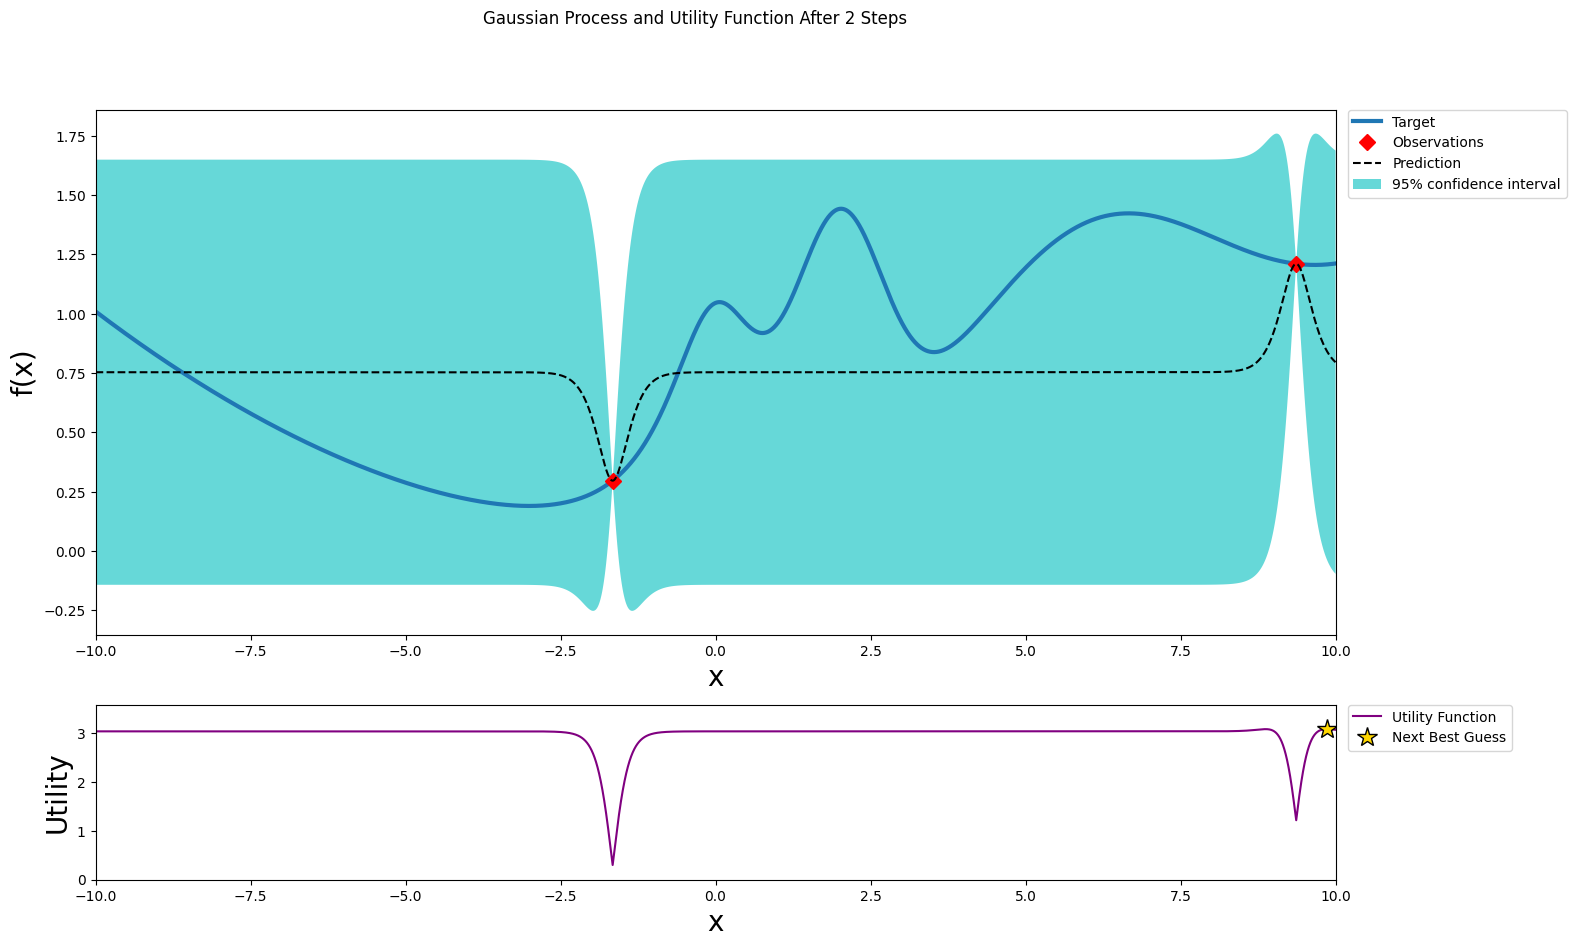

In [6]:
x = np.linspace(-10, 10, 10000).reshape(-1, 1)
y = target(x)
optimizer.maximize(
    init_points=0,
    n_iter=1,
    acquisition_function=utility
)
plot_gp(optimizer, x, y)

In [ ]:
# example of optimization base on the given utility function
for _ in range(5):
    next_point = optimizer.suggest(utility)
    target = black_box_func(**next_point)
    optimizer.register(params=next_point, target=target)

    print(f"utility:{target}, parameters:{next_point}")

In [ ]:
# working with discrete parameters:
#   just use param=int(param)